In [ ]:
# this notebook explores the winrate relation to time of day

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from math import acos, sqrt

In [10]:
df = pd.read_csv('tyler_24h.csv')
df = df.dropna()
print(df.shape)

(1650, 15)


In [11]:
opp_history_df = pd.read_csv('opp_24h.csv')
print(opp_history_df.shape)

(393756, 6)


In [12]:
import datetime
import math

def timestamp_to_radians(unix_timestamp):
    # Convert Unix timestamp to a datetime object
    time = datetime.datetime.fromtimestamp(unix_timestamp)

    # Extract hours, minutes, and seconds
    hours = time.hour
    minutes = time.minute
    seconds = time.second

    # Calculate total seconds since midnight
    total_seconds = hours * 3600 + minutes * 60 + seconds

    # Total number of seconds in a day
    seconds_in_day = 24 * 60 * 60

    # Map the seconds to the range of 0 to 2π
    radians = (total_seconds / seconds_in_day) * 2 * math.pi

    return radians


In [13]:
cos_col = {}
sin_col = {}
for index, row in df.iterrows():
    radians = timestamp_to_radians(row['unix'])
    cos_col[index] = math.cos(radians)
    sin_col[index] = math.sin(radians)
df['24h_cos'] = cos_col
df['24h_sin'] = sin_col

In [14]:
cos_col = {}
sin_col = {}
for index, row in opp_history_df.iterrows():
    radians = timestamp_to_radians(row['unix'])
    cos_col[index] = math.cos(radians)
    sin_col[index] = math.sin(radians)
opp_history_df['24h_cos'] = cos_col
opp_history_df['24h_sin'] = sin_col

In [15]:
df.head()

,unix,player_elo,opp_elo,opp_name,opp_30d,elo_diff,color,player_acc,opp_acc,acc_diff,won,num_reque,time_since_prev,opp_num_reque,opp_time_since_prev,24h_cos,24h_sin
0,1696185098,1090,1063,Quarini,249,27,False,69.43,62.25,7.18,1.0,0,0,2.0,325.0,-0.788995,-0.614400
1,1696186352,1097,1091,hgarciarod,339,6,True,78.20,69.40,8.80,1.0,0,1254,2.0,1108.0,-0.729765,-0.683698
2,1696187659,1105,1139,HERFJERF,113,-34,False,92.66,80.43,12.23,1.0,0,1307,0.0,48092.0,-0.661585,-0.749871
4,1696189372,1113,1105,InkLv,116,8,False,83.82,72.41,11.41,1.0,2,529,1.0,557.0,-0.563286,-0.826262
5,1696190619,1121,1105,alamrini,308,16,True,80.57,78.02,2.55,0.0,3,1247,0.0,5208.0,-0.486145,-0.873878


In [16]:
opp_history_df.head()

,unix,elo,elo_diff,color,won,reference_index,24h_cos,24h_sin
0,1693760070,890,-2,True,NaN,0,-0.971858,-0.235566
1,1694008792,890,-18,True,0.0,0,-0.865734,0.500504
2,1694009304,882,14,False,0.0,0,-0.883766,0.467930
3,1694110707,874,21,False,0.0,0,-0.823012,-0.568023
4,1694364931,866,-96,True,1.0,0,-0.970804,-0.239875


In [8]:
# Custom distance metric - arc length on the unit circle
def unit_circle_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    inner_product = x1*x2 + y1*y2
    # Clamp the inner product to the range [-1, 1] to avoid numerical issues
    inner_product = max(-1, min(1, inner_product))
    return acos(inner_product)

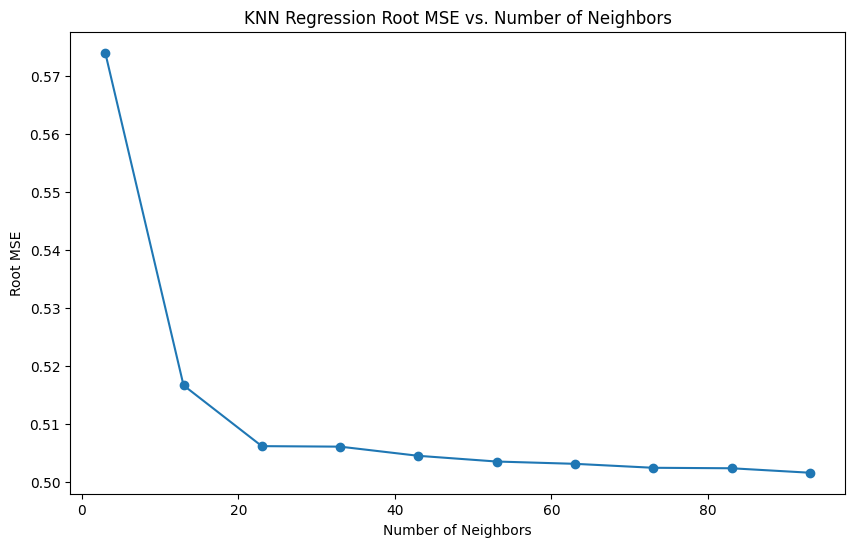

In [9]:
X = df[['24h_sin', '24h_cos']]
y = df['won']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

neighbors_range = range(3, 100, 10)

avg_scores = []

for n_neighbors in neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric=unit_circle_distance)

    scores = cross_val_score(knn, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    avg_scores.append(-np.mean(scores))

plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, avg_scores, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Root MSE')
plt.title('KNN Regression Root MSE vs. Number of Neighbors')
plt.show()


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

scores = {}

for n in range(33, 240, 8):
    n_scores = []

    for i in range(5):
        ## part 1, train KNN to predict winrate by time of day

        X = df[['24h_sin', '24h_cos']]
        y = df['won']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)

        knn = KNeighborsRegressor(n_neighbors=n, metric=unit_circle_distance)
        knn.fit(X_train, y_train)

        pred_rows = []

        for index, row in X_test.iterrows():
            input_df = pd.DataFrame([[row['24h_sin'], row['24h_cos']]], columns=['24h_sin', '24h_cos'])
            pred_regression = knn.predict(input_df)
            
            pred_rows.append({
                '24h_sin': row['24h_sin'],
                '24h_cos': row['24h_cos'],
                'won': y_test[index],
                'pred_regression': pred_regression[0]
            })

        pred_df = pd.DataFrame(pred_rows)

        ## part 2, use log regression to evaluate how accurate those winrates are

        X = pred_df[['pred_regression']]
        y = pred_df['won']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)

        y_pred = log_reg.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        n_scores.append(accuracy)

    scores[n] = np.mean(n_scores)


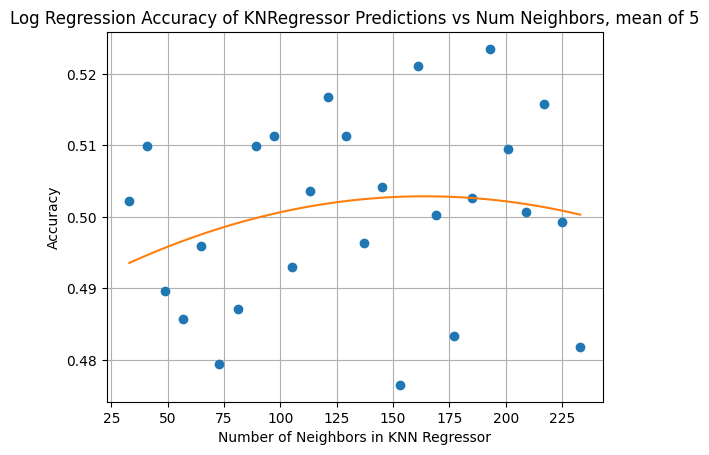

In [59]:
from numpy.polynomial.polynomial import Polynomial

x = np.array(list(scores.keys()))
y = np.array(list(scores.values()))

coefs = Polynomial.fit(x, y, 2).convert().coef

x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = coefs[0] + coefs[1]*x_smooth + coefs[2]*x_smooth**2

plt.plot(x, y, 'o')
plt.plot(x_smooth, y_smooth, '-')
plt.grid()
plt.title("Log Regression Accuracy of KNRegressor Predictions vs Num Neighbors, mean of 5")
plt.xlabel("Number of Neighbors in KNN Regressor")
plt.ylabel("Accuracy")
plt.show()